In [125]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [221]:
"""Main training script for Cascaded Nets."""
import argparse
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import torch
from collections import defaultdict
from datasets.dataset_handler import DataHandler
from matplotlib.lines import Line2D
from modules import utils
from scipy import interpolate

In [186]:
def setup_args():
  parser = argparse.ArgumentParser()
  parser.add_argument("--random_seed", type=int, default=42,
                      help="random seed")
  
  # Paths
  parser.add_argument("--experiment_root", type=str, 
                      default='experiments',
                      help="Local output dir")
#   parser.add_argument("--experiment_name", type=str, 
#                       required=True,
#                       help="Experiment name")
  
  # Dataset
#   parser.add_argument("--dataset_root", type=str, required=True,
#                       help="Dataset root")
#   parser.add_argument("--dataset_name", type=str, required=True,
#                       help="Dataset name: CIFAR10, CIFAR100, TinyImageNet")
  parser.add_argument("--split_idxs_root", type=str, default='split_idxs',
                      help="Split idxs root")
  parser.add_argument("--val_split", type=float, default=0.1,
                      help="Validation set split: 0.1 default")
  parser.add_argument("--augmentation_noise_type", type=str, 
                      default='occlusion',
                      help="Augmentation noise type: occlusion")
  parser.add_argument("--batch_size", type=int, default=128,
                      help="batch_size")
  parser.add_argument("--num_workers", type=int, default=2,
                      help="num_workers")
  parser.add_argument('--drop_last', action='store_true', default=False,
                      help='Drop last batch remainder')
  
  # Model
  parser.add_argument("--model_key", type=str, default='resnet18',
                      help="Model: resnet18, resnet34, ..., densenet_cifar")
  parser.add_argument("--train_mode", type=str, 
                      default='baseline',
                      help="Train mode: baseline, ic_only, sdn")
  parser.add_argument('--bn_time_affine', action='store_true', default=False,
                      help='Use temporal affine transforms in BatchNorm')
  parser.add_argument('--bn_time_stats', action='store_true', default=False,
                      help='Use temporal stats in BatchNorm')
  parser.add_argument("--tdl_mode", type=str, 
                      default='OSD',
                      help="TDL mode: OSD, EWS, noise")
  parser.add_argument("--tdl_alpha", type=float, default=0.0,
                      help="TDL alpha for EWS temporal kernel")
  parser.add_argument("--noise_var", type=float, default=0.0,
                      help="Noise variance on noise temporal kernel")
  parser.add_argument("--lambda_val", type=float, default=1.0,
                      help="TD lambda value")
  parser.add_argument('--cascaded', action='store_true', default=False,
                      help='Cascaded net')
  parser.add_argument("--cascaded_scheme", type=str, default='parallel',
                      help="cascaded_scheme: serial, parallel")
  parser.add_argument("--init_tau", type=float, default=0.01,
                      help="Initial tau valu")
  parser.add_argument("--target_IC_inference_costs", nargs="+", type=float, 
                      default=[0.15, 0.30, 0.45, 0.60, 0.75, 0.90],
                      help="target_IC_inference_costs")
  parser.add_argument('--tau_weighted_loss', action='store_true', default=False,
                      help='Use tau weights on IC losses')
  
  
  # Optimizer
  parser.add_argument("--learning_rate", type=float, default=0.1,
                      help="learning rate")
  parser.add_argument("--momentum", type=float, default=0.9,
                      help="momentum")
  parser.add_argument("--weight_decay", type=float, default=0.0005,
                      help="weight_decay")
  parser.add_argument('--nesterov', action='store_true', default=False,
                      help='Nesterov for SGD')
  parser.add_argument('--normalize_loss', action='store_true', default=False,
                      help='Normalize temporal loss')
  
  # LR scheduler
  parser.add_argument("--lr_milestones", nargs="+", type=float, 
                      default=[60, 120, 150],
                      help="lr_milestones")
  parser.add_argument("--lr_schedule_gamma", type=float, default=0.2,
                      help="lr_schedule_gamma")
  
  # Other
  parser.add_argument('--use_cpu', action='store_true', default=False,
                      help='Use cpu')
  parser.add_argument("--device", type=int, default=0,
                      help="GPU device num")
  parser.add_argument("--n_epochs", type=int, default=150,
                      help="Number of epochs to train")
  parser.add_argument("--eval_freq", type=int, default=10,
                      help="eval_freq")
  parser.add_argument("--save_freq", type=int, default=5,
                      help="save_freq")
  parser.add_argument('--keep_logits', action='store_true', default=False,
                      help='Keep logits')
  parser.add_argument('--debug', action='store_true', default=False,
                      help='Debug mode')
  
  args = parser.parse_args("")
  
  # Flag check
  if args.tdl_mode == 'EWS':
    assert args.tdl_alpha is not None, 'tdl_alpha not set'
  elif args.tdl_mode == 'noise':
    assert args.noise_var is not None, 'noise_var not set'
    
  return args

In [187]:
def add_error_bars(g, errors):
  try:
    # Find the x,y coordinates for each point
    x_coords = []
    y_coords = []
    for rect in g.ax.patches:
      x = rect.get_x() + rect.get_width() / 2
      y = rect.get_height()
      x_coords.append(x)
      y_coords.append(y)

    ax = g.fig.axes[0]
    # Calculate the type of error to plot as the error bars
    # Make sure the order is the same as the points were looped over
    ax.errorbar(x_coords, y_coords, yerr=errors, fmt=' ', 
                color='black', zorder=99)
  except:
    pass

In [533]:
args = setup_args()


args.dataset_root = '/hdd/mliuzzolino/datasets'
args.experiment_root = '/home/mliuzzolino/experiment_output'
  
# Set required flags|
args.dataset_name = 'ImageNet2012'  # CIFAR10, CIFAR100, ImageNet2012
args.model_key = 'resnet18'
args.dataset_key = 'test'  # val, test
if args.dataset_name == "ImageNet2012":
  args.experiment_name = f"{args.model_key}_{args.dataset_name}"
elif "cifar" in args.dataset_name.lower():
  args.experiment_name = f"{args.model_key}_{args.dataset_name.lower()}"
else:
  print("TinyImageNet not implemented yet!")
  
args.val_split = 0.1
args.test_split = 0.1
args.split_idxs_root = "/hdd/mliuzzolino/split_idxs"
args.tdl_mode = 'OSD'  # OSD, EWS
args.tau_weighted_loss = True
args.random_seed = 42

In [534]:
# Make reproducible
utils.make_reproducible(args.random_seed)

Making reproducible on seed 42


In [535]:
# Data Handler
data_dict = {
    "dataset_name": args.dataset_name,
    "data_root": args.dataset_root,
    "val_split": args.val_split,
    "test_split": args.test_split,
    "split_idxs_root": args.split_idxs_root,
    "noise_type": args.augmentation_noise_type,
    "load_previous_splits": True,
    "imagenet_params": {
      "target_classes": ["terrier"],
      "max_classes": 10,
    }
}
data_handler = DataHandler(**data_dict)

Setting split idxs root to /hdd/mliuzzolino/split_idxs/ImageNet2012
File aleady exists at /tmp/imagenet_labels.json.
Loading data from /tmp/imagenet_labels.json
Fin.
# Classes: 10
File aleady exists at /tmp/imagenet_labels.json.
Loading data from /tmp/imagenet_labels.json
Fin.
Loading splic locs from /hdd/mliuzzolino/split_idxs/ImageNet2012/0.1-0.1_val_test_split.json...
Loading train data...
10,530 train examples loaded.
Loading validation data...
1,170 train examples loaded.
Loading test data...
1,300 test examples loaded.
Complete.


In [536]:
# Set Loaders
test_loader = data_handler.build_loader(args.dataset_key, args)

In [537]:
# Set experiment root
exp_root = os.path.join(args.experiment_root,
                        args.experiment_name,
                        'experiments')

exp_root = f"/hdd/mliuzzolino/cascaded_nets/{args.experiment_name}/experiments"

# Find exp paths
exp_paths = np.sort(glob.glob(f'{exp_root}/*/outputs/*__{args.dataset_key}__{args.tdl_mode}.pt'))
print(f"Num paths: {len(exp_paths)}")

Num paths: 16


In [538]:
exp_root

'/hdd/mliuzzolino/cascaded_nets/resnet18_ImageNet2012/experiments'

In [539]:
n_cascaded = 4
n_sdn = 3
cascaded_palette = plt.cm.cool(np.linspace(0, 1, n_cascaded+2))[1:-1][:,:3][::-1]
sdn_palette = plt.cm.Oranges(np.linspace(0, 1, n_sdn+2))[1:-1][:,:3]

PALETTE = np.concatenate([cascaded_palette, sdn_palette])

In [540]:
df_dict = defaultdict(list)
outrep_id = 0
outreps_dict = {}
ic_costs_lookup = {}
exp_path_lookup = {}
for i, exp_path in enumerate(exp_paths):
  outrep_id = f'rep_id_{i}'
  outrep = torch.load(exp_path)
  
  basename = [ele for ele in exp_path.split(os.path.sep) if 'seed_' in ele][0]
  keys = basename.split(',')
  if keys[0].startswith('std') or keys[0].startswith('cascaded_seq'):
    model_key, lr, weight_decay, seed = keys
    td_key = 'std'
  else:
    td_key, scheme_key, lr, weight_decay, seed = keys[:5]
    model_key = f'cascaded__{scheme_key}'
    other_keys = keys[5:]
    multiple_fcs = 'multiple_fcs' in other_keys
    tau_weighted = 'tau_weighted' in other_keys
    pretrained_weights = 'pretrained_weights' in other_keys
    if multiple_fcs:
      model_key = f'{model_key}__multiple_fcs'
    if tau_weighted:
      model_key = f'{model_key}__tau_weighted'
    if pretrained_weights:
      model_key = f'{model_key}__pretrained_weights'

  if model_key != 'std':
    exp_root = os.path.dirname(os.path.dirname(exp_path))
    IC_cost_path = os.path.join(exp_root, 'ic_costs.pt')
    if os.path.exists(IC_cost_path):
      IC_costs = torch.load(IC_cost_path)
    else:
      IC_costs = None
  else:
    IC_costs = None
    
  lr = float(lr.split("_")[1])
  weight_decay = float(weight_decay.split("_")[1])

  df_dict['model'].append(model_key)
  df_dict['td_lambda'].append(td_key)
  df_dict['lr'].append(lr)
  df_dict['weight_decay'].append(weight_decay)
  df_dict['seed'].append(seed)
  df_dict['outrep_id'].append(outrep_id)
  
  outreps_dict[outrep_id] = outrep
  ic_costs_lookup[outrep_id] = IC_costs
  exp_path_lookup[outrep_id] = exp_path
analysis_df = pd.DataFrame(df_dict)

In [541]:
def print_model_lambda(df):
  for model_key, model_df in df.groupby('model'):
    for td_lambda, td_df in model_df.groupby('td_lambda'):
      print(model_key, td_lambda)

In [542]:
print_model_lambda(analysis_df)

cascaded__parallel td(0.0)
cascaded__serial__multiple_fcs td(0.0)
cascaded__serial__multiple_fcs td(1.0)
cascaded_seq__parallel std
cascaded_seq__serial std
std std


# Stats

In [543]:
df_dict = defaultdict(list)
analysis_df = analysis_df.sort_values('model')
for i, df_i in analysis_df.iterrows():
  outrep_i = outreps_dict[df_i.outrep_id]
  accs = outrep_i['correct'].float().mean(dim=1)
  
  for i, acc in enumerate(accs):
    df_dict['acc'].append(acc.item() * 100)
    if len(accs) == 1:
      i = -1
    df_dict['ic'].append(i)
    for k in list(df_i.index):
      df_dict[k].append(df_i[k])
accs_df = pd.DataFrame(df_dict)

In [544]:
print_model_lambda(accs_df)

cascaded__parallel td(0.0)
cascaded__serial__multiple_fcs td(0.0)
cascaded__serial__multiple_fcs td(1.0)
cascaded_seq__parallel std
cascaded_seq__serial std
std std


In [545]:
accs_df = accs_df.sort_values(['outrep_id', 'ic'])

df_dict = defaultdict(list)
for model_key, model_df in accs_df.groupby('model'):
  for td_lambda, lambda_df in model_df.groupby('td_lambda'):
    for ic, ic_df in lambda_df.groupby('ic'):
      mean_acc = np.mean(ic_df.acc)
      sem_acc = np.std(ic_df.acc) / np.sqrt(len(ic_df.acc))
      outrep_id = ic_df.outrep_id.iloc[0]
      df_dict['model'].append(model_key)
      df_dict['td_lambda'].append(td_lambda)
      df_dict['ic'].append(ic)
      df_dict['acc'].append(mean_acc)
      df_dict['sem'].append(sem_acc)
      df_dict['outrep_id'].append(outrep_id)
      
      flops = ic_costs_lookup[outrep_id]
      if flops is not None:
        try:
          flops = flops['flops'][ic]
        except:
          flops = 1.0
      df_dict['flops'].append(flops)
stats_df = pd.DataFrame(df_dict)
stats_df.loc[stats_df.ic==-1, 'ic'] = np.max(stats_df.ic)
stats_df.ic = [ele+1 for ele in stats_df.ic]

In [546]:
print_model_lambda(stats_df)

cascaded__parallel td(0.0)
cascaded__serial__multiple_fcs td(0.0)
cascaded__serial__multiple_fcs td(1.0)
cascaded_seq__parallel std
cascaded_seq__serial std
std std


In [547]:
MODEL_LBL_LOOKUP = {
    "cascaded__serial": "SerialTD",
    "cascaded__parallel": "CascadedTD",
    "cascaded__serial__multiple_fcs": "SerialTD-MultiHead",  # (SDN)
    "cascaded__parallel__multiple_fcs": "CascadedTD-MultiHead",
    "cascaded_seq__serial": "SerialCE",
    "cascaded_seq__parallel": "CascadedCE",
}

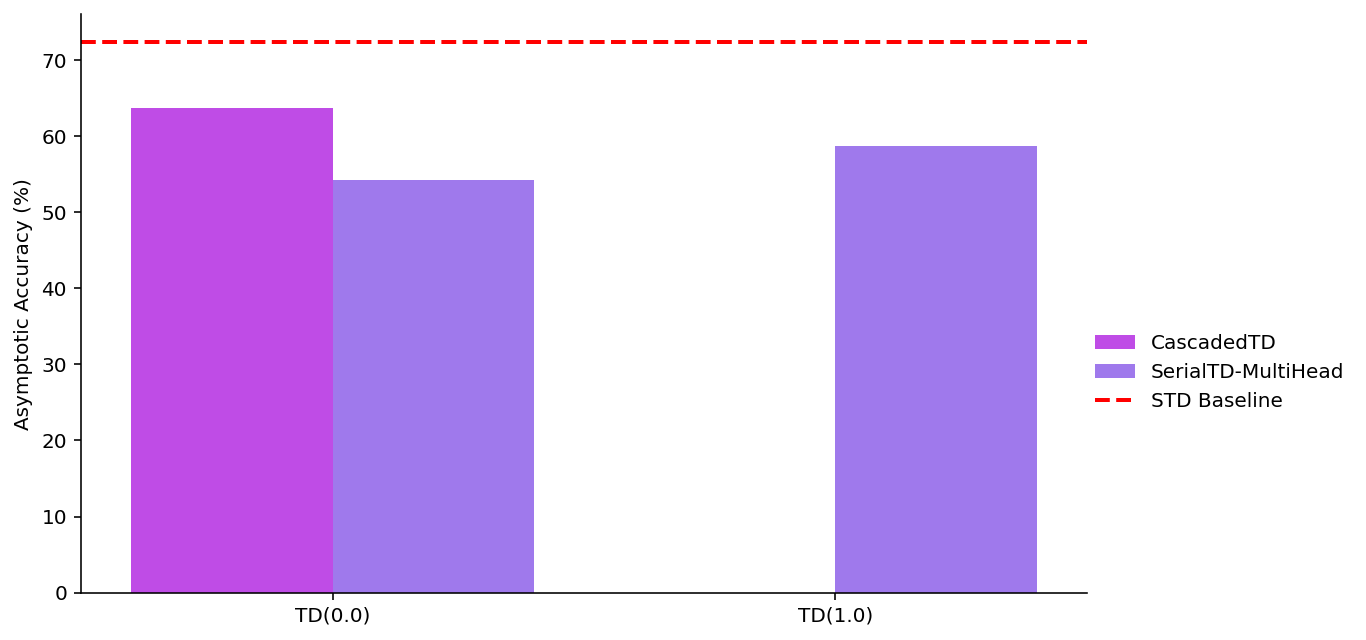

In [548]:
plot_df = stats_df[(stats_df.model!='std')]
plot_df = plot_df[~plot_df.model.str.contains('seq')]
plot_dfs = []
for model_key, model_df in plot_df.groupby('model'):
  model_df = model_df[model_df.ic==model_df.ic.max()]
  plot_dfs.append(model_df)
plot_df = pd.concat(plot_dfs)
plot_df.td_lambda = [ele.replace('td', 'TD') for ele in plot_df.td_lambda]
std_df = stats_df[stats_df.model=='std']
if len(std_df):
  std_acc = std_df.iloc[0].acc
else:
  std_acc = 0

g = sns.catplot(kind='bar', x='td_lambda', y='acc', hue='model', 
                data=plot_df, palette=PALETTE)
add_error_bars(g, errors=plot_df['sem'])

g._legend.set_title('Model')
g._legend.remove()
g.ax.set_xlabel('')
g.ax.set_ylabel('Asymptotic Accuracy (%)')
g.ax.axhline(std_acc, c='r', linestyle='--', lw=2)

if args.dataset_name == 'CIFAR10':
  g.ax.set_ylim(84, 93)
elif args.dataset_name == 'CIFAR100':
  g.ax.set_ylim(50, 70)
elif args.dataset_name == 'TinyImageNet':
  g.ax.set_ylim(50, 70)
  
baseline_patch = Line2D([0], [0], color='red', lw=2, 
                        linestyle='--', label='STD Baseline')
handles, labels = g.ax.get_legend_handles_labels()
for handle in handles:
  new_label = MODEL_LBL_LOOKUP[handle.get_label()]
  handle.set_label(new_label)
handles += [baseline_patch]
plt.legend(handles=handles, loc=(1,0.3), frameon=False)
g.fig.set_size_inches(12.5, 4.5)

In [549]:
SDN_TD1 = True
best_lambdas = {}
for model_key, model_df in stats_df.groupby('model'):
  model_df = model_df[model_df.ic==model_df.ic.max()] 
  model_df = model_df[model_df.acc==model_df.acc.max()]
  best_lambda = model_df.iloc[0].td_lambda
  if SDN_TD1:
#     if model_key == 'cascaded__serial__multiple_fcs':
    if 'cascaded__serial' in model_key:
#     if 'sdn' in model_key:
      best_lambdas[model_key] = 'td(1.0)'
    elif 'cascaded__parallel' in model_key:
      best_lambdas[model_key] = 'td(0.0)'
    else:
      best_lambdas[model_key] = best_lambda
  else:
    best_lambdas[model_key] = best_lambda
best_lambdas

{'cascaded__parallel': 'td(0.0)',
 'cascaded__serial__multiple_fcs': 'td(1.0)',
 'cascaded_seq__parallel': 'std',
 'cascaded_seq__serial': 'std',
 'std': 'std'}

In [550]:
# std_df = stats_df[stats_df.model.str.contains('std')]
# td_dfs = stats_df[~stats_df.td_lambda.str.contains('std')]
# casc_seq_df = stats_df[stats_df.model.str.contains('_seq')]
# td_dfs = td_dfs[td_dfs.td_lambda.str.contains('0.0')]
# for ic_i, ic_df in td_dfs.groupby('ic'):
#   casc_seq_df.loc[casc_seq_df.ic == ic_i, 'flops'] = ic_df.iloc[0].flops
# td_df = pd.concat([td_dfs, casc_seq_df])
# max_flop = np.max(td_df.flops)

# td_df.drop(columns=['outrep_id'], inplace=True)

# plt.figure(figsize=(8,6))
# for i, (model_key, model_df) in enumerate(td_df.groupby('model')):
#   flops = list(model_df.flops)
#   acc = list(model_df.acc)
  
#   linestyle = '--' if 'multiple_fcs' in model_key else '-'
#   if 'cascaded_seq' in model_key:
#     if 'serial' in model_key:
#       color_i = cm[0]
#       linestyle = std_ls
#     elif 'parallel' in model_key:
#       color_i = cm[1]
#       linestyle = std_ls
#   else:
#     if 'serial' in model_key:
#       color_i = cm[0]
#     elif 'parallel' in model_key:
#       color_i = cm[1]
      
#   if flops[-1] < max_flop:
#     flops.append(max_flop)
#     acc.append(acc[-1])

#   plt.plot(flops, acc, label=MODEL_LBL_LOOKUP[model_key], 
#            linewidth=4, c=color_i, ls=linestyle)
# # std_flops = np.linspace(0, max_flop, 10)
# # std_acc = [1/data_handler.num_classes * 100 for _ in std_flops]
# # std_acc[-1] = std_df.iloc[0].acc

# # plt.plot(std_flops, std_acc,  
# #          linewidth=4, color='r', linestyle='--')
# # #   plt.axhline(std_acc, linestyle='--', c='r', lw=2)

# # baseline_patch = Line2D([0], [0], color='red', lw=2, 
# #                         linestyle='--', label='Sequential')
# ax = plt.gca()
# handles, labels = ax.get_legend_handles_labels()
# # handles += [baseline_patch]

# legend = ax.legend(handles=handles, frameon=False, loc='center left', 
#                    bbox_to_anchor=(1., 0.5), prop={'size': LEGEND_FONTSIZE})
# fig.subplots_adjust(right=0.9)
  
# #   plt.legend(loc=(1,0.5), frameon=False)
# plt.xlabel('GFLOPS')
# plt.ylabel('Accuracy (%)')

## Inference Cost as it varies with confidence threshold, q

In [551]:
def compute_threshold_conf_correct(pred_conf, correct, q):
  correct_arr = []
  best_clf_idxs = []
  n_clfs = pred_conf.shape[0]
  n_samples = pred_conf.shape[1]
  for i in range(n_samples):
    pred_conf_i = pred_conf[:,i]
    idxs = np.where(pred_conf_i >= q)[0]
    if not len(idxs):
      best_clf_idx = n_clfs - 1
      cor_i = correct[best_clf_idx,i]
    else:
      best_clf_idx = idxs[0]
      cor_i = correct[best_clf_idx,i]
    correct_arr.append(cor_i)
    best_clf_idxs.append(best_clf_idx)
  avg_acc = np.mean(correct_arr)
  return avg_acc, best_clf_idxs

In [552]:
df_dict = defaultdict(list)
for model_key, model_df in analysis_df.groupby('model'):
  if model_key == 'cascaded_seq__serial':
    delta = 100
  else:
    delta = 100
  Qs = np.linspace(0, 1, delta)
  
  if model_key in ['std']:
    continue
    
  print(f"\nModel: {model_key}")
  for td_lambda, td_df in model_df.groupby('td_lambda'):
    for jj, df_i in td_df.iterrows():
      outrep_id = df_i.outrep_id
      outrep_i = outreps_dict[outrep_id]
      try:
        flop_costs = ic_costs_lookup[outrep_id]['flops']
      except:
        for k, v in ic_costs_lookup.items():
          if v is not None:
            flop_costs = v['flops']
            break
      
      f_interpolate = interpolate.interp1d(range(len(flop_costs)), flop_costs, bounds_error=False)

      prediction_confidence = outrep_i['prediction_confidence']
      correct_vals = outrep_i['correct']

      accs = []
      flops = []
      for qi, q in enumerate(Qs):
        sys.stdout.write((f'\rTD_lambda: {td_lambda} -- '
                          f'df_{jj} [{jj+1}/{len(td_df)}] -- '
                          f'Threshold, q: {q:0.2f} [{qi+1}/{len(Qs)}]'))
        sys.stdout.flush()
        acc_i, best_clf_idxs = compute_threshold_conf_correct(prediction_confidence, correct_vals, q)
        avg_timesteps = np.mean(best_clf_idxs)
        avg_flop = f_interpolate(avg_timesteps)
        
        flops.append(avg_flop)
        df_dict['model'].append(model_key)
        df_dict['td_lambda'].append(td_lambda)
        df_dict['seed'].append(df_i.seed)
        df_dict['acc'].append(acc_i * 100)
        df_dict['flops'].append(avg_flop)
        df_dict['timesteps'].append(avg_timesteps)
        df_dict['q'].append(q)
      print("\n")
x_df = pd.DataFrame(df_dict)


Model: cascaded__parallel
TD_lambda: td(0.0) -- df_9 [10/3] -- Threshold, q: 1.00 [100/100]

TD_lambda: td(0.0) -- df_10 [11/3] -- Threshold, q: 1.00 [100/100]

TD_lambda: td(0.0) -- df_11 [12/3] -- Threshold, q: 1.00 [100/100]


Model: cascaded__serial__multiple_fcs
TD_lambda: td(0.0) -- df_12 [13/1] -- Threshold, q: 1.00 [100/100]

TD_lambda: td(1.0) -- df_13 [14/3] -- Threshold, q: 1.00 [100/100]

TD_lambda: td(1.0) -- df_14 [15/3] -- Threshold, q: 1.00 [100/100]

TD_lambda: td(1.0) -- df_15 [16/3] -- Threshold, q: 1.00 [100/100]


Model: cascaded_seq__parallel
TD_lambda: std -- df_0 [1/3] -- Threshold, q: 1.00 [100/100]

TD_lambda: std -- df_1 [2/3] -- Threshold, q: 1.00 [100/100]

TD_lambda: std -- df_2 [3/3] -- Threshold, q: 1.00 [100/100]


Model: cascaded_seq__serial
TD_lambda: std -- df_3 [4/3] -- Threshold, q: 1.00 [100/100]

TD_lambda: std -- df_4 [5/3] -- Threshold, q: 1.00 [100/100]

TD_lambda: std -- df_5 [6/3] -- Threshold, q: 1.00 [100/100]



In [553]:
def fix_df(df_src, key='cascaded_seq__serial'):
  df_src = df_src.copy()
  df = df_src[df_src.model==key]
  df = df.sort_values('timestep_mean')
  prev_j = None
  for i, j in df.iterrows():
    if j.timestep_mean != 0.0:
      break
    prev_j = j

  for t in np.linspace(prev_j.timestep_mean, j.timestep_mean, 10)[:-1]:
    new_j = prev_j.copy()
    new_j.timestep_mean = t
    new_j.timestep_mean = t
    df = df.append(new_j, ignore_index=True)
  df = df.sort_values('timestep_mean')
  
  df_src.drop(df_src[df_src.model==key].index, inplace=True)
  df_src = pd.concat([df_src, df])
  
  return df_src

### Plot Individual

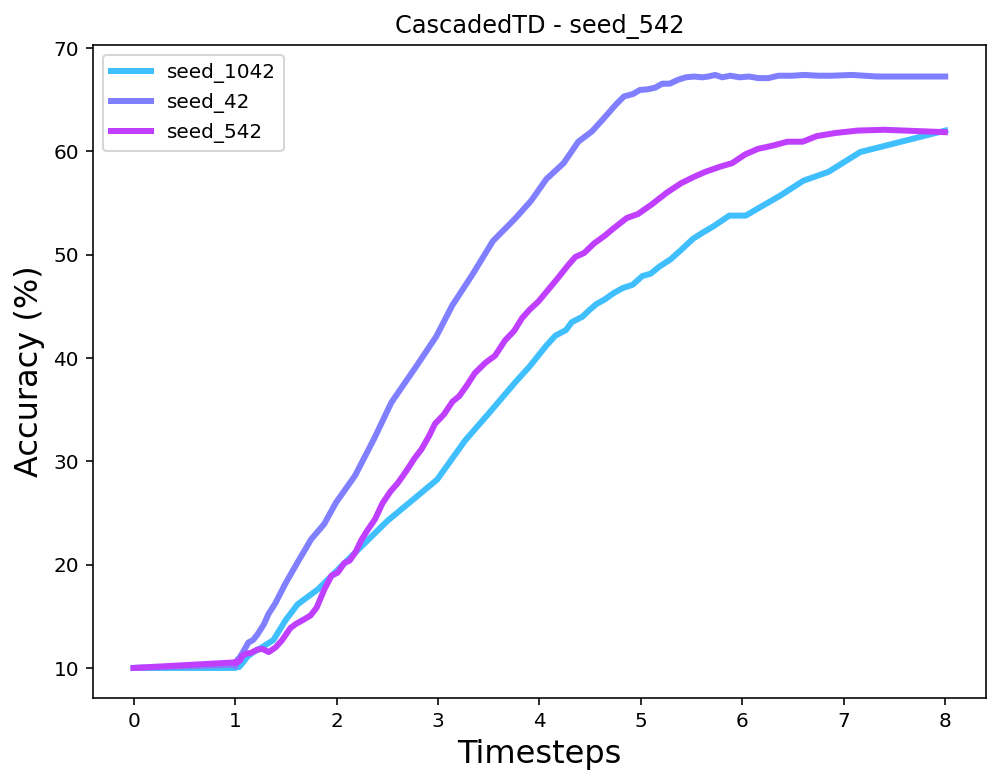

<Figure size 432x288 with 0 Axes>

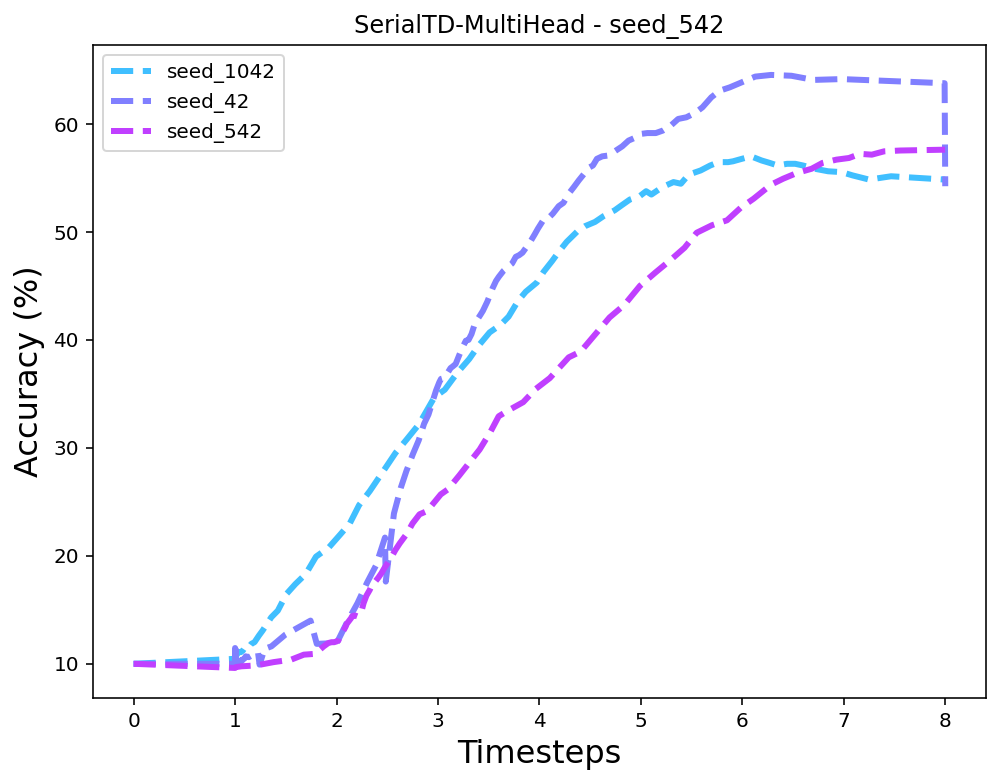

<Figure size 432x288 with 0 Axes>

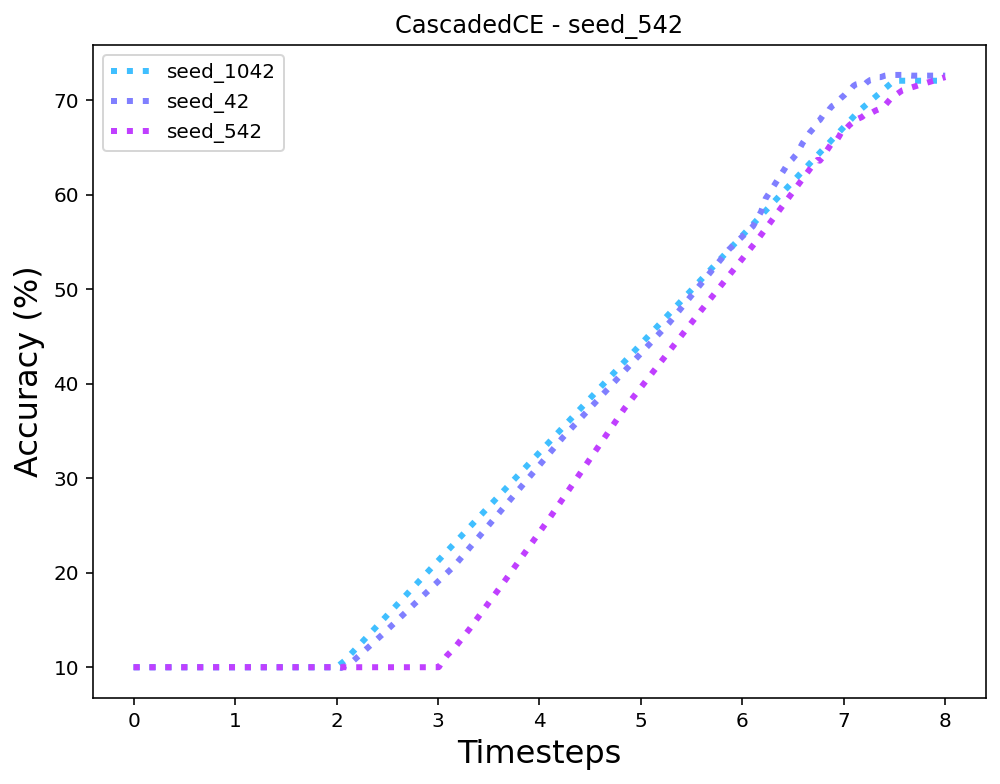

<Figure size 432x288 with 0 Axes>

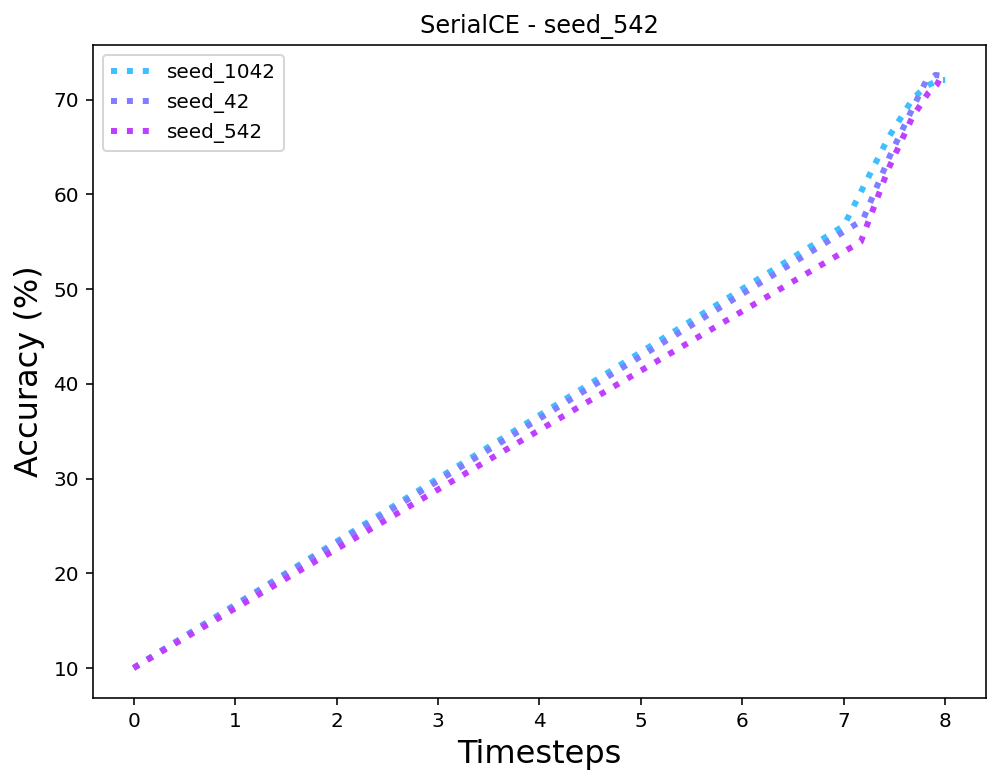

<Figure size 432x288 with 0 Axes>

In [554]:
SHOW_EBARS = True
LINEWIDTH = 3
AXIS_LBL_FONTSIZE = 16
LEGEND_FONTSIZE = 16
TICK_FONTSIZE = 14

for i, (model_key, model_df) in enumerate(x_df.groupby('model')):
  fig = plt.figure(figsize=(8,6))
  n_seeds = model_df.seed.unique().shape[0]
  seed_colors = plt.cm.cool(np.linspace(0, 1, n_seeds+2))[1:-1]
  for j, (seed_key, seed_df) in enumerate(model_df.groupby("seed")):
    linestyle = '--' if 'multiple_fcs' in model_key else '-'
    if 'cascaded_seq' in model_key:
      linestyle = 'dotted'
  
    color_i = seed_colors[j]
    timestep_vals = np.array(list(seed_df.timesteps))
    sorted_idxs = np.argsort(timestep_vals)
    timestep_vals = timestep_vals[sorted_idxs]
    acc_vals = np.array(list(seed_df.acc))[sorted_idxs]
    
    try:
      label = MODEL_LBL_LOOKUP[model_key]
    except:
      label = "cascaded__scheme_1__multiple_fcs"
    plt.plot(timestep_vals, acc_vals, label=seed_key, 
             linewidth=LINEWIDTH, c=color_i, linestyle=linestyle)

    plt.xlabel('Timesteps', fontsize=AXIS_LBL_FONTSIZE)
    plt.ylabel('Accuracy (%)', fontsize=AXIS_LBL_FONTSIZE)
    plt.title(f"{label} - {seed_key}")
    plt.legend()
    
  plt.show()
  plt.clf()

### Agg Stats

In [555]:
single_seed = 42

In [556]:
df_dict = defaultdict(list)
for model_key, model_df in x_df.groupby('model'):
  for td_lambda, td_df in model_df.groupby('td_lambda'):
    for q, q_df in td_df.groupby('q'):
      if single_seed:
        q_df = q_df[q_df.seed.str.contains(f"_{single_seed}")]
      acc_mean = np.mean(q_df.acc)
      n = len(q_df)
      acc_sem = np.std(q_df.acc) / np.sqrt(n)
      timestep_mean = np.mean(q_df.timesteps)
      timestep_sem = np.std(q_df.timesteps) / np.sqrt(n)

      df_dict['model'].append(model_key)
      df_dict['q'].append(q)
      df_dict['acc_mean'].append(acc_mean)
      df_dict['acc_sem'].append(acc_sem)
      df_dict['timestep_mean'].append(timestep_mean)
      df_dict['timestep_sem'].append(timestep_sem)
      df_dict['td_lambda'].append(td_lambda)
      df_dict['n'].append(n)
q_stat_df = pd.DataFrame(df_dict)

In [557]:
try:
  q_stat_df = fix_df(q_stat_df, 'cascaded_seq__serial')
except:
  print("Exception!")

In [558]:
print_model_lambda(q_stat_df)

cascaded__parallel td(0.0)
cascaded__serial__multiple_fcs td(0.0)
cascaded__serial__multiple_fcs td(1.0)
cascaded_seq__parallel std
cascaded_seq__serial std


### MetaCog Model

In [559]:
_SHOW_METACOG = False

In [560]:
# metacog_path = f'metacog/results/{args.dataset_name}/results.pt'
# metacog_df = torch.load(metacog_path)
# len(metacog_df)

In [561]:
# plt.plot(metacog_df.mean_time, metacog_df.mean_correct*100)

In [562]:
# metacog_df = metacog_df.sort_values('mean_time')
# prev_j = None
# for i, j in metacog_df.iterrows():
#   if j.mean_time != 0.0:
#     break
#   prev_j = j
  
# for t in np.linspace(prev_j.mean_time, j.mean_time, 10):
#   new_j = prev_j.copy()
#   new_j.mean_time = t
#   new_j.median_time = t
#   metacog_df = metacog_df.append(new_j, ignore_index=True)
# len(metacog_df)

### Setup Figs

In [563]:
figs_root = 'figs'
if not os.path.exists(figs_root):
  os.makedirs(figs_root)
  
fig_path = os.path.join(figs_root, f'{args.dataset_name}.pdf')
fig_path

'figs/ImageNet2012.pdf'

In [564]:
colors_src = {
    "CascadedTDColor": np.array([182,54,121]) / 255.0,  # CascadedTDColor,
    "CascadedCEColor": np.array([127,38,110]) / 255.0,  # CascadedCEColor,
    "SerialTDColor": np.array([77,184,255]) / 255.0,  # SerialTDColor,
    "SerialCEColor": np.array([54,129,179]) / 255.0,  # SerialCEColor,
}

model_colors = {
    "cascaded__serial": colors_src["SerialTDColor"],
    "cascaded__parallel": colors_src["CascadedTDColor"],
    "cascaded__serial__multiple_fcs": colors_src["SerialTDColor"],  # (SDN)
    "cascaded__parallel__multiple_fcs": colors_src["CascadedTDColor"],
    "cascaded_seq__serial": colors_src["SerialCEColor"],
    "cascaded_seq__parallel": colors_src["CascadedCEColor"],
}

In [565]:
def fix_legend_order(handles, labels):
  order = [
      'CascadedTD', 
      'CascadedTD-MultiHead', 
      'CascadedCE',
      'SerialTD', 
      'SerialTD-MultiHead', 
      'SerialCE',
  ]
  idxs = []
  for key in order:
    if key in labels:
      idx = labels.index(key)
      idxs.append(idx)
  handles = list(np.array(handles)[idxs])
  labels = list(np.array(labels)[idxs])
  return handles, labels

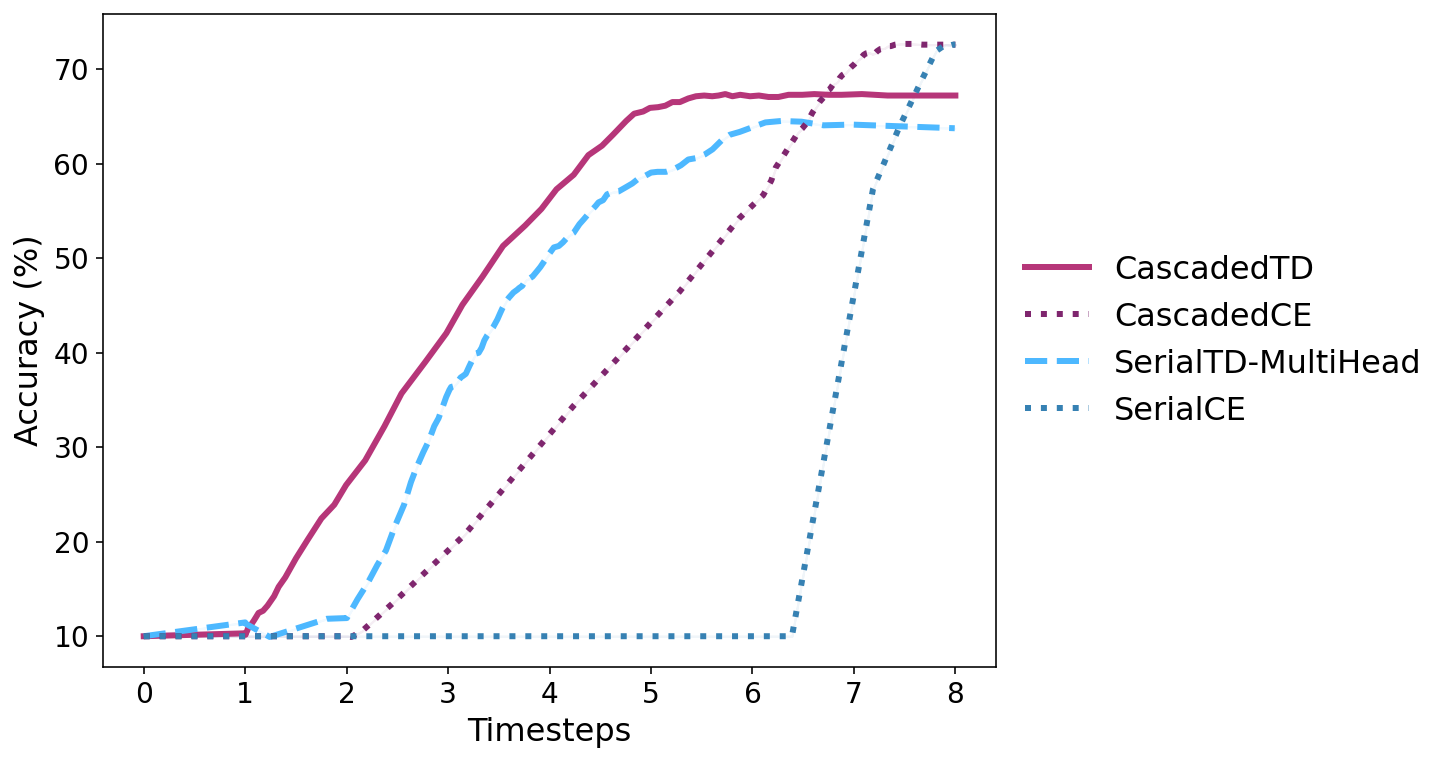

In [566]:
SHOW_EBARS = True
LINEWIDTH = 3
AXIS_LBL_FONTSIZE = 16
LEGEND_FONTSIZE = 16
TICK_FONTSIZE = 14
fig = plt.figure(figsize=(8,6))

y_dfs = []
for model_key, model_df in q_stat_df.groupby('model'):
  best_lambda = best_lambdas[model_key]
  model_df = model_df[model_df.td_lambda==best_lambda]
  y_dfs.append(model_df)
q_stat_df_fixed = pd.concat(y_dfs)

max_flop = np.max(q_stat_df_fixed.timestep_mean)

for i, (model_key, model_df) in enumerate(q_stat_df_fixed.groupby('model')):
  linestyle = '--' if 'multiple_fcs' in model_key else '-'
  if 'cascaded_seq' in model_key:
    linestyle = 'dotted'
  try:
    color_i = model_colors[model_key]
  except:
    color_i = model_colors["cascaded__parallel__multiple_fcs"]
  
  timestep_vals = np.array(list(model_df.timestep_mean))
  
  sorted_idxs = np.argsort(timestep_vals)
  timestep_vals = timestep_vals[sorted_idxs]
  acc_vals = np.array(list(model_df.acc_mean))[sorted_idxs]
  sem_error = np.array(list(model_df.acc_sem))[sorted_idxs]
#   if timestep_vals[-1] < max_flop:
#     timestep_vals.append(max_flop)
#     acc_vals.append(acc_vals[-1])
#     sem_error.append(sem_error[-1])
    
  td_lambda_lbl = model_df.iloc[0].td_lambda.replace('td(', 'TD(')
  try:
    label = MODEL_LBL_LOOKUP[model_key]
  except:
    label = "cascaded__scheme_1__multiple_fcs"
  plt.plot(timestep_vals, acc_vals, label=label, 
           linewidth=LINEWIDTH, c=color_i, linestyle=linestyle)
  
  if SHOW_EBARS:
    lower_b = np.array(acc_vals) - np.array(sem_error)
    upper_b = np.array(acc_vals) + np.array(sem_error)
    plt.fill_between(timestep_vals, lower_b, upper_b, alpha=0.075, color=color_i)
  
plt.xlabel('Timesteps', fontsize=AXIS_LBL_FONTSIZE)
plt.ylabel('Accuracy (%)', fontsize=AXIS_LBL_FONTSIZE)

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
handles, labels = ax.get_legend_handles_labels()
handles, labels = fix_legend_order(handles, labels)
ax.legend(handles=handles, labels=labels)
                   
final_fig_path = fig_path
if 'metacog_df' in globals() and _SHOW_METACOG:
  final_fig_path = final_fig_path.replace('.pdf', '_with_metacog.pdf')
  metacog_df = metacog_df.sort_values('mean_time')
  metacog_time = metacog_df.mean_time
  metacog_acc = metacog_df.mean_correct * 100
  metacog_color = np.array((255, 148, 77)) / 255.
  metacog_ls = (0, (3, 1, 1, 1))
  plt.plot(metacog_time, metacog_acc, 
           linewidth=LINEWIDTH, color=metacog_color, linestyle=metacog_ls)
  metacog_patch = Line2D([0], [0], color=metacog_color, lw=LINEWIDTH, 
                         linestyle=metacog_ls, label='MetaCog GRU-RNN')

  handles += [metacog_patch]

legend = ax.legend(handles=handles, frameon=False, loc='center left', 
                   bbox_to_anchor=(1., 0.5), prop={'size': LEGEND_FONTSIZE})
fig.subplots_adjust(right=0.9)
  
plt.savefig(final_fig_path, dpi=300, bbox_inches='tight')
plt.savefig(final_fig_path.replace('pdf', 'png'), dpi=300, bbox_inches='tight')

In [567]:
model_df

,model,q,acc_mean,acc_sem,timestep_mean,timestep_sem,td_lambda,n
0,cascaded_seq__serial,0.000000,10.000000,0.0,0.0,0.0,std,1
11,cascaded_seq__serial,0.050505,10.000000,0.0,0.0,0.0,std,1
10,cascaded_seq__serial,0.010101,10.000000,0.0,0.0,0.0,std,1
100,cascaded_seq__serial,0.050505,10.000000,0.0,0.0,0.0,std,1
8,cascaded_seq__serial,0.030303,10.000000,0.0,0.0,0.0,std,1
...,...,...,...,...,...,...,...,...
47,cascaded_seq__serial,0.939394,72.615385,0.0,8.0,0.0,std,1
46,cascaded_seq__serial,0.949495,72.615385,0.0,8.0,0.0,std,1
45,cascaded_seq__serial,0.959596,72.615385,0.0,8.0,0.0,std,1
53,cascaded_seq__serial,0.878788,72.615385,0.0,8.0,0.0,std,1


In [568]:
for i, (model_key, model_df) in enumerate(q_stat_df_fixed.groupby('model')):
  label = MODEL_LBL_LOOKUP[model_key]
  final_df = model_df[model_df.timestep_mean==model_df.timestep_mean.max()].iloc[0]
  acc = final_df.acc_mean
  sem = final_df.acc_sem
  print(f"{label}: {acc:0.2f}% +/- {sem:0.2f} (n={final_df.n})")
  
  xp = list(model_df.acc_mean)
  fp = list(model_df.timestep_mean)
  t_for_50_perc = np.interp(50, xp, fp)
  print(f"{label}: 50% accuracy @ timestep {t_for_50_perc:0.2f}")
  print("\n")

CascadedTD: 67.23% +/- 0.00 (n=1)
CascadedTD: 50% accuracy @ timestep 3.46


SerialTD-MultiHead: 63.77% +/- 0.00 (n=1)
SerialTD-MultiHead: 50% accuracy @ timestep 3.97


CascadedCE: 72.62% +/- 0.00 (n=1)
CascadedCE: 50% accuracy @ timestep 5.55


SerialCE: 72.62% +/- 0.00 (n=1)
SerialCE: 50% accuracy @ timestep 7.06




In [569]:
model_df[model_df.timestep_mean==model_df.timestep_mean.max()].acc_mean

80    72.615385
79    72.615385
78    72.615385
77    72.615385
76    72.615385
        ...    
47    72.615385
46    72.615385
45    72.615385
53    72.615385
54    72.615385
Name: acc_mean, Length: 76, dtype: float64

## Model Comparisons

Would it be difficult to make a speed-accuracy curve for 
1. CascadedTD (lambda=0), 
2. CascadedTD (lambda=1), 
3. SerialTD (lambda=0), 
4. serialTD(lambda=1)

In [276]:
MODEL_LBL_LOOKUP

{'cascaded__serial': 'SerialTD',
 'cascaded__parallel': 'CascadedTD',
 'cascaded__serial__multiple_fcs': 'SerialTD-MultiHead',
 'cascaded__parallel__multiple_fcs': 'CascadedTD-MultiHead',
 'cascaded_seq__serial': 'SerialCE',
 'cascaded_seq__parallel': 'CascadedCE'}

In [277]:
RQs = [
    "",
]

comparison_pairs = [
  (
    ('cascaded__serial__multiple_fcs', 'TD1'), 
    ('cascaded__serial__multiple_fcs', 'best'),
#     ('cascaded__parallel', 'TD1'),
    ('cascaded__parallel', 'best'),
  ),
]

In [278]:
# RQs = [
#     "",
# ]

# comparison_pairs = [
#   (('cascaded__serial', 'TD1'), 
#    ('cascaded__serial', 'best'),
#    ('cascaded__parallel', 'TD1'),
#    ('cascaded__parallel', 'best'),),
# ]

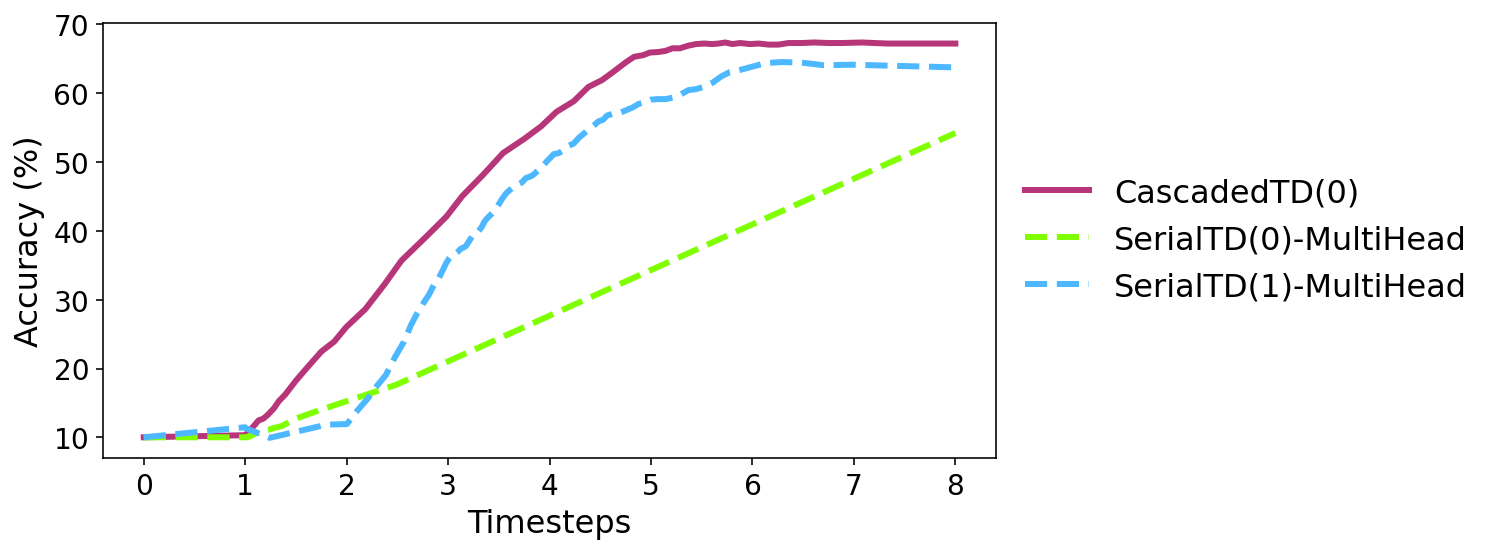

In [279]:
line_styles = ['-', '--', '-.', 'dotted']
n_models = len(np.unique(q_stat_df.model))

LINEWIDTH = 3
AXIS_LBL_FONTSIZE = 16
LEGEND_FONTSIZE = 16
TICK_FONTSIZE = 14

n_figs = len(comparison_pairs)
fig, axes = plt.subplots(n_figs, figsize=(8,4*n_figs))
if n_figs == 1:
  axes = [axes]

for comp_i, comparison_pair in enumerate(comparison_pairs):
  RQ = RQs[comp_i]
  ax = axes[comp_i]
  
  subset_df = []
  for key_i, (key, td_val) in enumerate(comparison_pair):
    df_i = q_stat_df[q_stat_df.model==key]
    if td_val == 'TD1':
      if False: # key == 'cascaded__parallel':
        df_i = df_i[df_i.td_lambda=='td(0.5)']
        df_i['td_lambda'] = ['td(1.0)' for ele in df_i.td_lambda]
      else:
        df_i = df_i[df_i.td_lambda=='td(1.0)']
    else:
      lambdas = []
      accs = []
      for td_lambda, td_df in df_i.groupby('td_lambda'):
        acc = td_df[td_df.q==td_df.q.max()].iloc[0].acc_mean
        accs.append(acc)
        lambdas.append(td_lambda)
      best_idx = np.argmax(accs)
      if key == 'cascaded__serial__multiple_fcs' and td_val == 'best':
        best_idx = lambdas.index('td(0.0)')
      elif key == 'cascaded__parallel' and td_val == 'TD1':
        best_idx = lambdas.index('td(0.5)')
      elif key == 'cascaded__parallel' and td_val == 'best':
        best_idx = lambdas.index('td(0.0)')
      best_lambda = lambdas[best_idx]
      df_i = df_i[df_i.td_lambda==best_lambda]

    subset_df.append(df_i)
  subset_df = pd.concat(subset_df)
  max_flop = np.max(subset_df.timestep_mean)
#   for model_key, model_df in subset_df.groupby('model'):
#     subset_df = fix_df(subset_df, model_key)
  
  for i, (model_key, model_df) in enumerate(subset_df.groupby('model')):
  #   if 'parallel' not in model_key:
  #     continue
    if 'cascaded_seq' in model_key:
      continue
    
    linestyle = '--' if 'multiple_fcs' in model_key else '-'
    
    for j, (td_lambda, td_df) in enumerate(model_df.groupby('td_lambda')):
      acc_vals = list(td_df.acc_mean)
      sem_error = list(td_df.acc_sem)
      timestep_vals = list(td_df.timestep_mean)
      if model_key == 'cascaded__serial__multiple_fcs' and td_lambda == 'td(0.0)':
        color_i = np.array([127, 255, 0]) / 255.0
      else:
        color_i = model_colors[model_key]
#         color_i = model_colors[model_key].copy()
#         new_R = min(1.0, color_i[0] * 0.1*j)
#         new_G = min(1.0, color_i[1] * 0.2*j)
#         color_i[0] = new_R
#         color_i[1] = new_G
      
      if timestep_vals[-1] < max_flop:
        timestep_vals.append(max_flop)
        acc_vals.append(acc_vals[-1])
        sem_error.append(sem_error[-1])

      label = MODEL_LBL_LOOKUP[model_key]
      td_int = int(td_lambda.split("(")[1].split(".")[0])
      label = label.replace('TD', f'TD({td_int})')
      ax.plot(timestep_vals, acc_vals, label=label, 
              linewidth=LINEWIDTH, c=color_i, linestyle=linestyle)

  ax.set_xlabel('Timesteps', fontsize=AXIS_LBL_FONTSIZE)
  ax.set_ylabel('Accuracy (%)', fontsize=AXIS_LBL_FONTSIZE)
  ax.set_title(RQ)
#   ax = plt.gca()
  ax.tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
  handles, labels = ax.get_legend_handles_labels()
  # handles.insert(2, baseline_patch)

  final_fig_path = fig_path.replace('.pdf', '_RQs.pdf')
  if 'metacog_df' in globals() and _SHOW_METACOG:
    final_fig_path = final_fig_path.replace('.pdf', '_with_metacog.pdf')
    metacog_df = metacog_df.sort_values('mean_time')
    metacog_time = metacog_df.mean_time
    metacog_acc = metacog_df.mean_correct * 100
    metacog_color = np.array((255, 148, 77)) / 255.
    metacog_ls = (0, (3, 1, 1, 1))
    plt.plot(metacog_time, metacog_acc, 
             linewidth=LINEWIDTH, color=metacog_color, linestyle=metacog_ls)
    metacog_patch = Line2D([0], [0], color=metacog_color, lw=LINEWIDTH, 
                           linestyle=metacog_ls, label='MetaCog GRU-RNN')

    handles += [metacog_patch]

  legend = ax.legend(handles=handles, frameon=False, loc='center left', 
                     bbox_to_anchor=(1., 0.5), prop={'size': LEGEND_FONTSIZE})
  fig.subplots_adjust(right=0.9, hspace=0.4)
  
fig3_path = final_fig_path.replace('.pdf', '_fig3.pdf')
plt.savefig(fig3_path, dpi=300, bbox_inches='tight')
plt.savefig(fig3_path.replace('pdf', 'png'), dpi=300, bbox_inches='tight')

### Other Comparison
In terms of the SDN simulation, the conditions I can see worth talking about are:
1. parallel, single exit, optimizing lambda (CascadedTD)
2. parallel, multiple exits, optimizing lambda
3. parallel, multiple exits, lambda = 1
4. serial, single exit, lambda = 1
5. serial, multiple exits, optimizing lambda
6. serial, multiple exits, lambda = 1 (SDN)

Does SDN benefit from TD? Compare 6 and 5

Does SDN benefit from multiple exits? Compare 6 and 4

Does SDN benefit from parallel? Compare 6 and 3

Does Cascaded benefit from multiple exits? Compare 1 vs. 2


In [280]:
RQs = [
    "Does Cascaded benefit from TD?",
    "Does SDN benefit from TD?",
    "Does SDN benefit from multiple exits?",
    "Does SDN benefit from parallel?",
    "Does Cascaded benefit from multiple exits?"
]

comparison_pairs = [
  (('cascaded__parallel', 'TD1'), ('cascaded__parallel', 'best')),
  (('cascaded__serial__multiple_fcs', 'TD1'), ('cascaded__serial__multiple_fcs', 'best')),
  (('cascaded__serial__multiple_fcs', 'TD1'), ('cascaded__serial', 'TD1')),
  (('cascaded__serial__multiple_fcs', 'TD1'), ('cascaded__parallel__multiple_fcs', 'TD1')),
  (('cascaded__parallel', 'best'), ('cascaded__parallel__multiple_fcs', 'best')),
]

ValueError: attempt to get argmax of an empty sequence

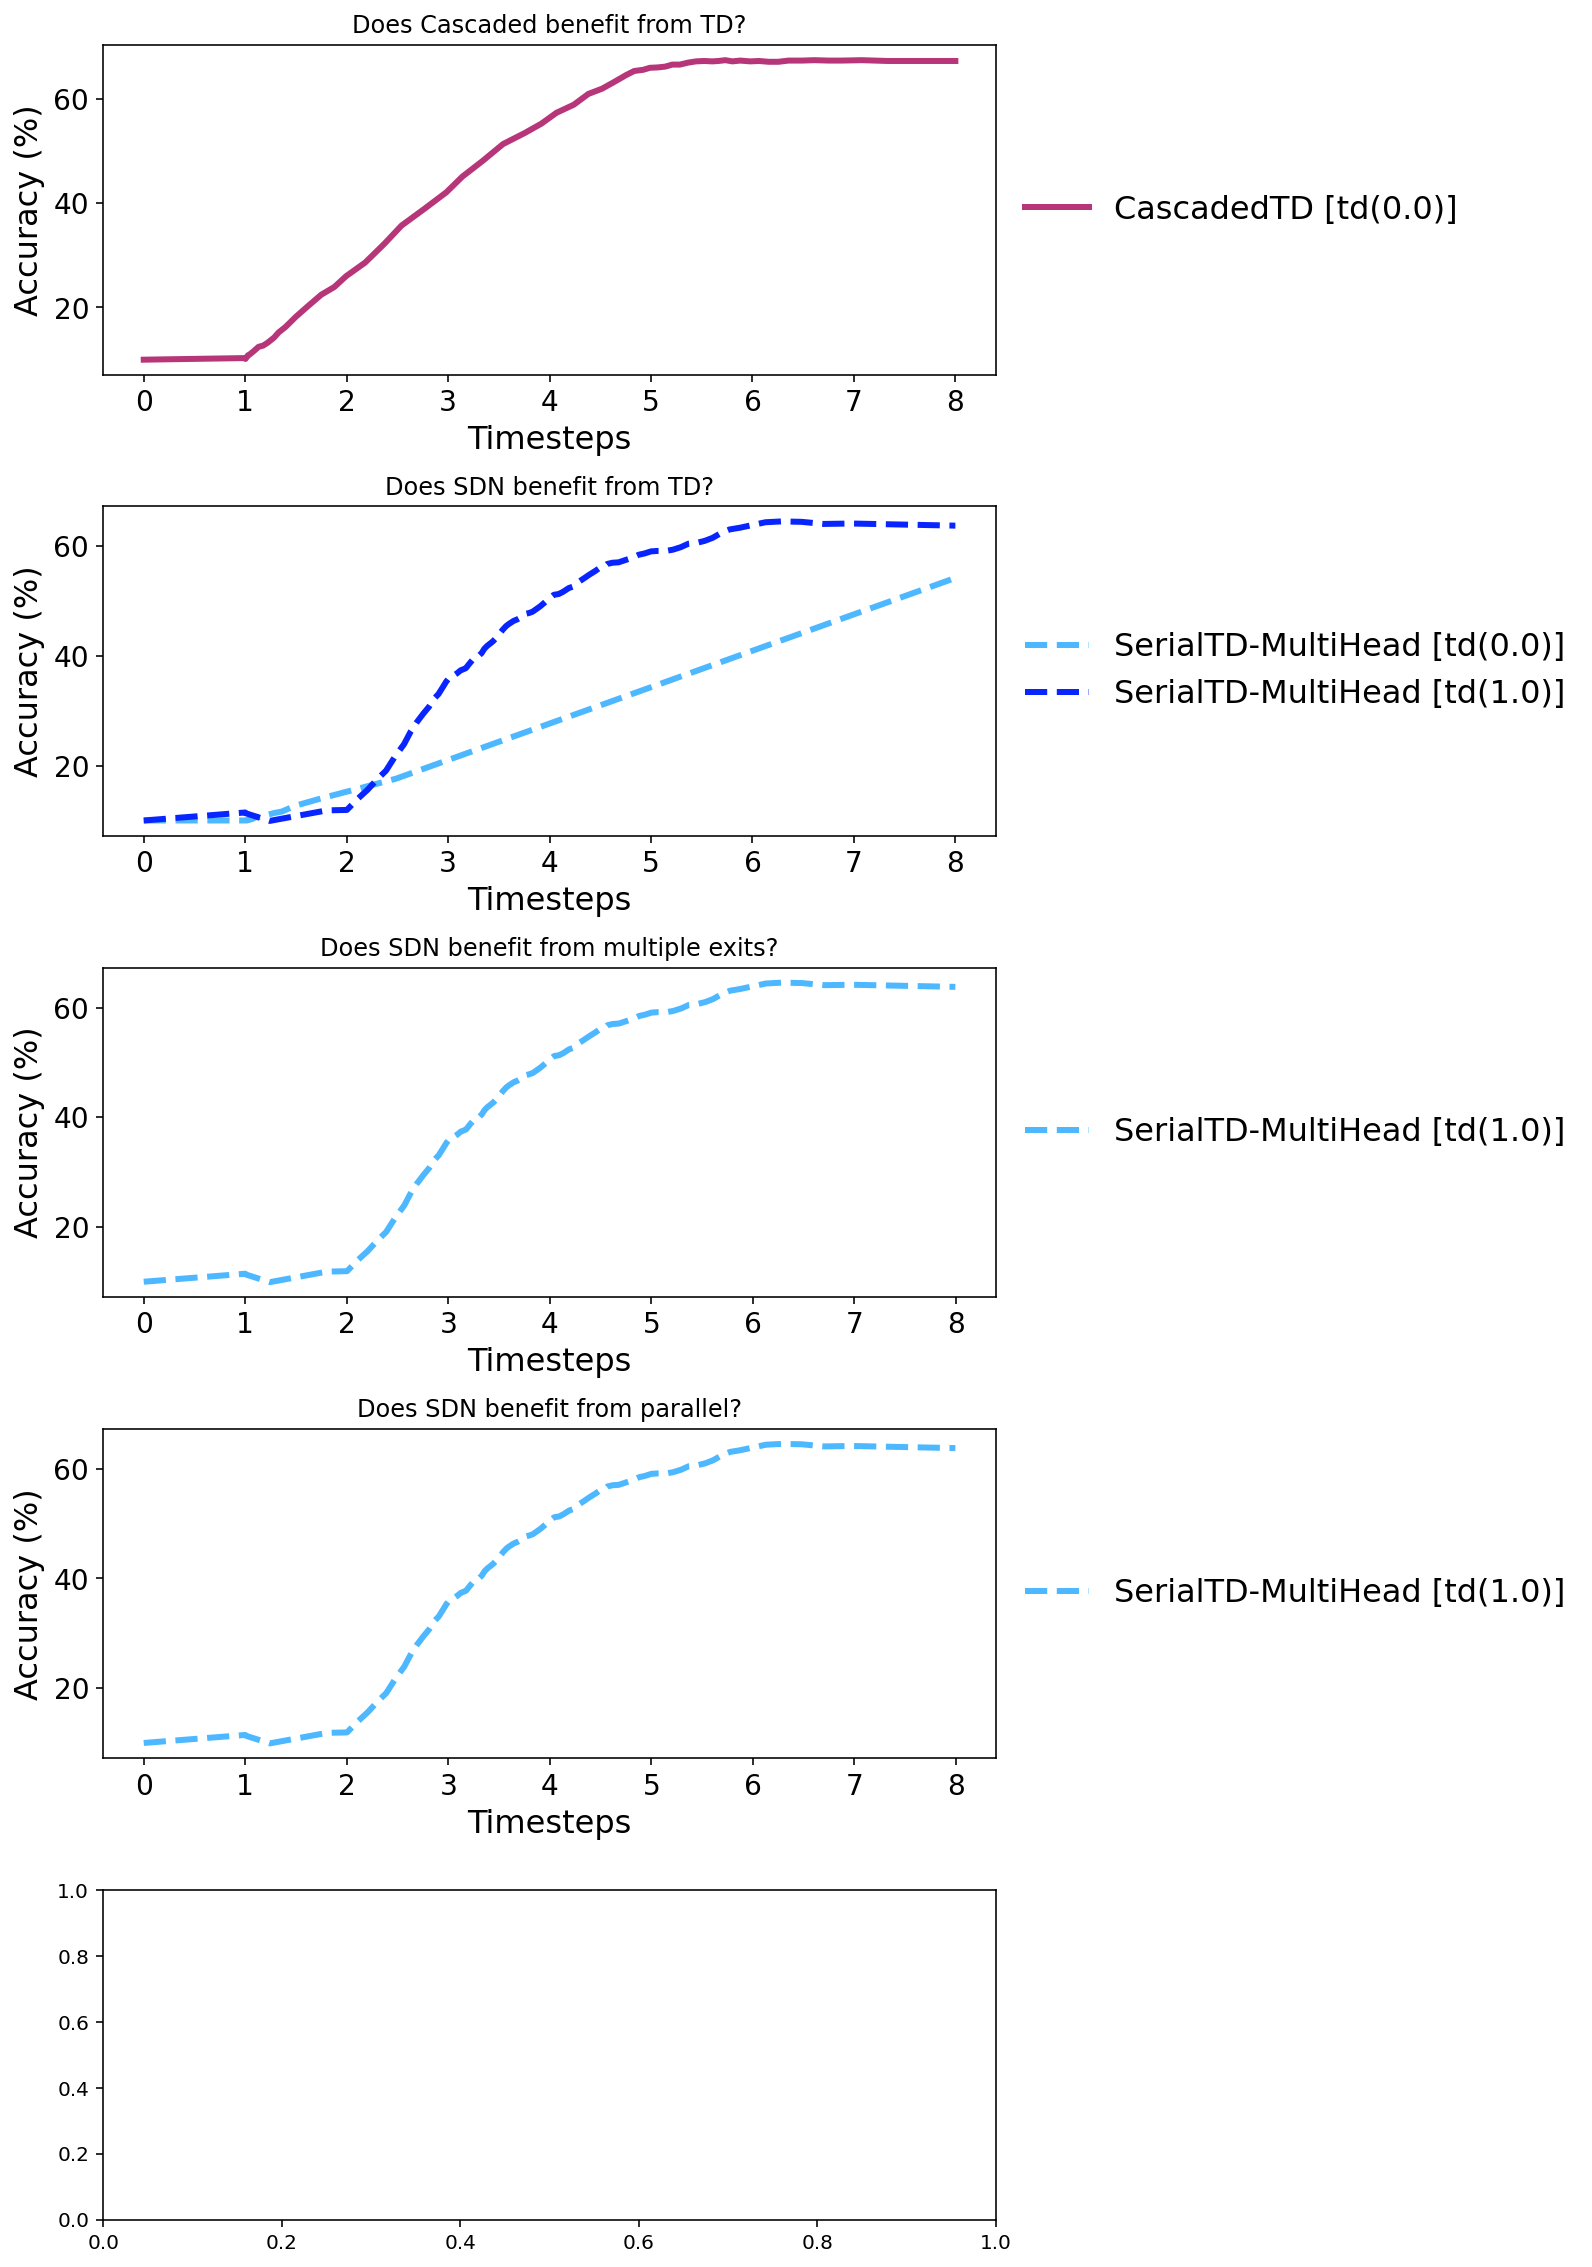

In [281]:
line_styles = ['-', '--', '-.', 'dotted']
n_models = len(np.unique(q_stat_df.model))

LINEWIDTH = 3
AXIS_LBL_FONTSIZE = 16
LEGEND_FONTSIZE = 16
TICK_FONTSIZE = 14

n_figs = len(comparison_pairs)
fig, axes = plt.subplots(n_figs, figsize=(8,4*n_figs))
if n_figs == 1:
  axes = [axes]

for comp_i, comparison_pair in enumerate(comparison_pairs):
  RQ = RQs[comp_i]
  ax = axes[comp_i]
  
  subset_df = []
  for key_i, (key, td_val) in enumerate(comparison_pair):
    df_i = q_stat_df[q_stat_df.model==key]
    if td_val == 'TD1':
      if False: # key == 'cascaded__parallel':
        df_i = df_i[df_i.td_lambda=='td(0.5)']
        df_i['td_lambda'] = ['td(1.0)' for ele in df_i.td_lambda]
      else:
        df_i = df_i[df_i.td_lambda=='td(1.0)']
    else:
      lambdas = []
      accs = []
      for td_lambda, td_df in df_i.groupby('td_lambda'):
        acc = td_df[td_df.q==td_df.q.max()].iloc[0].acc_mean
        accs.append(acc)
        lambdas.append(td_lambda)
      best_idx = np.argmax(accs)
      if key == 'cascaded__serial__multiple_fcs' and td_val == 'best':
        best_idx = lambdas.index('td(0.0)')
      elif key == 'cascaded__parallel' and td_val == 'TD1':
        best_idx = lambdas.index('td(0.5)')
      best_lambda = lambdas[best_idx]
      df_i = df_i[df_i.td_lambda==best_lambda]

    subset_df.append(df_i)
  subset_df = pd.concat(subset_df)
  max_flop = np.max(subset_df.timestep_mean)
#   for model_key, model_df in subset_df.groupby('model'):
#     subset_df = fix_df(subset_df, model_key)
  
  for i, (model_key, model_df) in enumerate(subset_df.groupby('model')):
  #   if 'parallel' not in model_key:
  #     continue
    if 'cascaded_seq' in model_key:
      continue
    color_i = model_colors[model_key]
    linestyle = '--' if 'multiple_fcs' in model_key else '-'
    if 'cascaded_seq' in model_key:
      linestyle = 'dotted'
    for j, (td_lambda, td_df) in enumerate(model_df.groupby('td_lambda')):
      acc_vals = list(td_df.acc_mean)
      sem_error = list(td_df.acc_sem)
      timestep_vals = list(td_df.timestep_mean)
      if j > 0:
        color_i = model_colors[model_key].copy()
        new_R = min(1.0, color_i[0] * 0.1*j)
        new_G = min(1.0, color_i[1] * 0.2*j)
        color_i[0] = new_R
        color_i[1] = new_G

      if timestep_vals[-1] < max_flop:
        timestep_vals.append(max_flop)
        acc_vals.append(acc_vals[-1])
        sem_error.append(sem_error[-1])

      label = MODEL_LBL_LOOKUP[model_key]
      label = f'{label} [{td_lambda}]'
      ax.plot(timestep_vals, acc_vals, label=label, 
              linewidth=LINEWIDTH, c=color_i, linestyle=linestyle)

  ax.set_xlabel('Timesteps', fontsize=AXIS_LBL_FONTSIZE)
  ax.set_ylabel('Accuracy (%)', fontsize=AXIS_LBL_FONTSIZE)
  ax.set_title(RQ)
#   ax = plt.gca()
  ax.tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
  handles, labels = ax.get_legend_handles_labels()
  # handles.insert(2, baseline_patch)

  final_fig_path = fig_path.replace('.pdf', '_RQs.pdf')
  if 'metacog_df' in globals() and _SHOW_METACOG:
    final_fig_path = final_fig_path.replace('.pdf', '_with_metacog.pdf')
    metacog_df = metacog_df.sort_values('mean_time')
    metacog_time = metacog_df.mean_time
    metacog_acc = metacog_df.mean_correct * 100
    metacog_color = np.array((255, 148, 77)) / 255.
    metacog_ls = (0, (3, 1, 1, 1))
    plt.plot(metacog_time, metacog_acc, 
             linewidth=LINEWIDTH, color=metacog_color, linestyle=metacog_ls)
    metacog_patch = Line2D([0], [0], color=metacog_color, lw=LINEWIDTH, 
                           linestyle=metacog_ls, label='MetaCog GRU-RNN')

    handles += [metacog_patch]

  legend = ax.legend(handles=handles, frameon=False, loc='center left', 
                     bbox_to_anchor=(1., 0.5), prop={'size': LEGEND_FONTSIZE})
  fig.subplots_adjust(right=0.9, hspace=0.4)
plt.savefig(final_fig_path, dpi=300, bbox_inches='tight')
plt.savefig(final_fig_path.replace('pdf', 'png'), dpi=300, bbox_inches='tight')

## Asymptotic

In [ ]:
print("Asymptotic Performance")
print("----------------------")
for model_key, model_df in q_stat_df.groupby('model'):
  asymptotic_df = model_df[model_df.flops_mean==model_df.flops_mean.max()]
  asymptotic_df = asymptotic_df.iloc[0]
  flops_val = asymptotic_df.flops_mean
  acc_val = asymptotic_df.acc_mean
  sem_val = asymptotic_df.acc_sem
  model_name = MODEL_LBL_LOOKUP[model_key]
  print(f"{model_name:40s} {acc_val:0.2f} +/- {sem_val:0.2f}")
  
std_name = "Sequential"
std_acc_val = std_df.iloc[0]['acc']
std_sem_val = std_df.iloc[0]['sem']
print(f"{std_name:40s} {std_acc_val:0.2f} +/- {std_sem_val:0.2f}")

In [ ]:
import torch
import numpy as np

In [ ]:
p = "/hdd/mliuzzolino/debug_delete_this/resnet18_CIFAR100/experiments/td(0.0),parallel,lr_0.01,wd_0.0005,seed_42/outputs/emeddings__test__OSD.npy"

In [ ]:
d = np.load(p, allow_pickle=True)

In [ ]:
d.shape

In [ ]:
for k, v in d.items():
  print(k)
  break

In [ ]:
v